In [1]:
# Importing libraries
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from sklearn.metrics import mean_squared_error

# seed configuration
np.random.seed(38)
torch.manual_seed(38)

In [2]:
df = pd.read_csv('preprocessed_data.csv')
df.head()

,date,holiday,total power consumption,temp_mean
0,2011-11-23,0,90.39,8.46
1,2011-11-24,0,213.41,10.12
2,2011-11-25,0,303.99,8.48
3,2011-11-26,0,420.98,12.28
4,2011-11-27,0,444.88,7.42


In [3]:
# skip this line if yours is total_power_consumption
df = df.rename(columns = {'total power consumption' : 'total_power_consumption'})
df.head()

,date,holiday,total_power_consumption,temp_mean
0,2011-11-23,0,90.39,8.46
1,2011-11-24,0,213.41,10.12
2,2011-11-25,0,303.99,8.48
3,2011-11-26,0,420.98,12.28
4,2011-11-27,0,444.88,7.42


In [4]:
# remove holiday and temp_mean
df.drop(['holiday', 'temp_mean'], axis=1, inplace=True)
df.head()

,date,total_power_consumption
0,2011-11-23,90.39
1,2011-11-24,213.41
2,2011-11-25,303.99
3,2011-11-26,420.98
4,2011-11-27,444.88


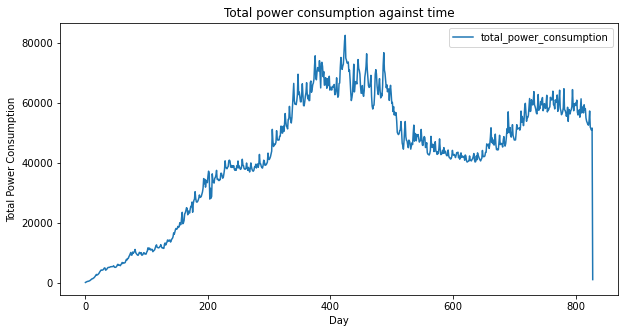

In [5]:
df.plot(figsize=(10,5))
plt.xlabel("Day")
plt.ylabel("Total Power Consumption")
plt.title("Total power consumption against time")
plt.show()

We can see that there are two columns, date and power consumption. Let's inspect the data type for each column

In [6]:
# compute dtype
for column in df.columns:
    print(f"The data type for '{column}' column is: {df[column].dtype}")

The data type for 'date' column is: object
The data type for 'total_power_consumption' column is: float64


Now, we will compute the descriptive statistics

In [7]:
df.describe()

,total_power_consumption
count,829.000000
mean,42870.715489
std,20141.286955
min,90.390000
25%,34421.900000
50%,45846.580000
75%,58795.510000
max,82650.490000


The descriptive statistics computed are the mean, standard deviation, minimum and maximum values. We see that the maximum value is 82650.490000 and minimum value is 90.390000, and the standard deviation is 20141.286955. This shows that the power consumption volume varies by a large spread. Next, we will plot a time plot for the data.

In [8]:
#remove the last data point (because the last data point suddenly drop)
df = df.iloc[:-1]

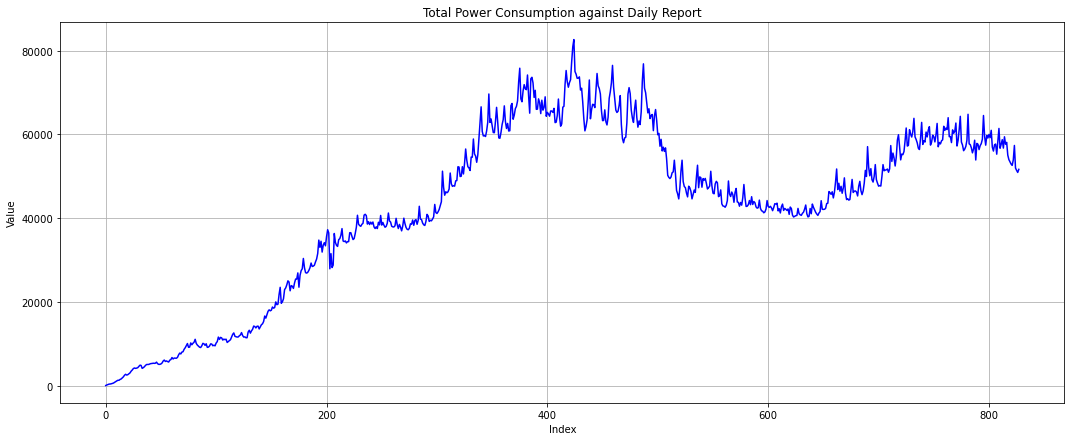

In [9]:
# plot time plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Total Power Consumption against Daily Report")
ax.grid(b=True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df['total_power_consumption'],
    color='blue', label='Data');

Now that we get to feel the ebb and flow of the data. Let's split the dataset into training and test set

In [10]:
#split dataset
df_train, df_test = train_test_split(df, train_size=0.7, shuffle=False)

#display training dataset length
print(f"The length of training dataset is: {len(df_train)}")

#display test dataset length
print(f"The length of test dataset is: {len(df_test)}")

The length of training dataset is: 579
The length of test dataset is: 249


Let's see what are the portions of dataset which are splitted as training dataset and test dataset.

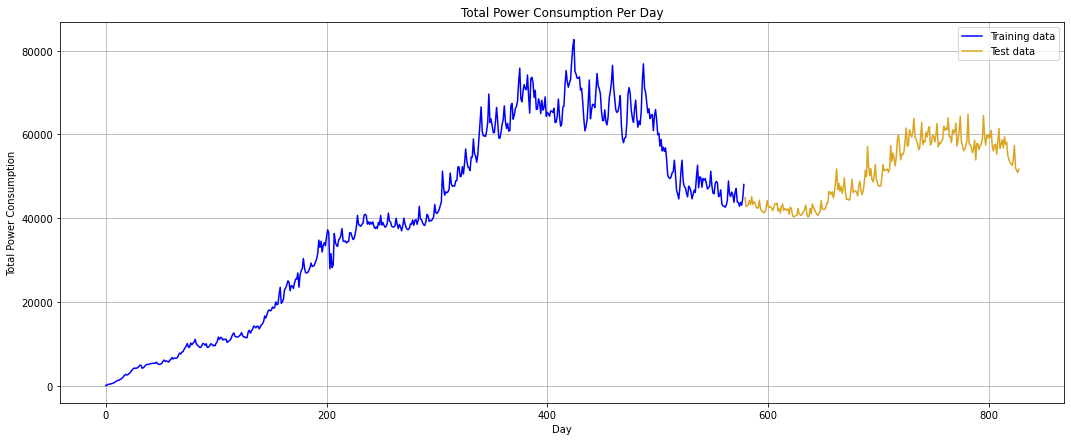

In [11]:
# plot time plot for training and test dataset 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Total Power Consumption Per Day")
ax.grid(b=True)
ax.set_xlabel("Day")
ax.set_ylabel("Total Power Consumption")
ax.plot(
    df_train['total_power_consumption'],
    color='blue', label='Training data');
ax.plot(
    df_test['total_power_consumption'],
    color='goldenrod', label='Test data')
ax.legend();

Feature scaling also help in shortening model training time. Let's do that too.

In [12]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train['total_power_consumption'].values.reshape(-1,1))
test_scaled = scaler.transform(df_test['total_power_consumption'].values.reshape(-1,1))

### Model Deployment

The torch library provides a number of API to easily construct a MLP model for the tasks at hand. But first, we will need to prepare the dataset into a format ingestible by the model first. We will first transform the time series data into feature of label, where the feature would be a sequence of n length of data and label would be lead-1 of the last data in the feature.


In [13]:
# write a helper function which slices through the features using the sequence_length parameter and index the label at the time step
# function should return features in sequence and labels
def sequencing_data(data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be in np.ndarray.
    """
    x, y = [], []

    for i in range(data.shape[0] - sequence_length):

        # copy the sequences of data starting at this index
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return x, y

# calling the helper function and store them in variables
X_sequence_train, y_sequence_train = sequencing_data(train_scaled, 3)
X_sequence_test, y_sequence_test = sequencing_data(test_scaled, 3)

# sanity check 
print("Total samples for X train: " + str(len(X_sequence_train)))
print("Total samples for y train: " + str(len(y_sequence_train)))
print("Total samples for X test: " + str(len(X_sequence_test)))
print("Total samples for y test: " + str(len(y_sequence_test)))

Total samples for X train: 576
Total samples for y train: 576
Total samples for X test: 246
Total samples for y test: 246


Let's write a custom Dataset class to transform the data into tuples of torch.Tensor. This is necessary if we want to load the data in batches using DataLoader.

In [14]:
class PowerDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """ 
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

We will write the codes to convert data into Dataset object and then into DataLoader object. We will be using a batch size of 4 for this DataLoader object.

In [15]:
# declare batch size
batch_size = 4

# convert into Dataset using customized class
train_Dataset = PowerDataset(X_sequence_train, y_sequence_train)
test_Dataset = PowerDataset(X_sequence_test, y_sequence_test)

# convert into DataLoader
train_loader = DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_Dataset, batch_size=batch_size, shuffle=False)

# declare a dict object
dataloaders = {'train': train_loader, 'test': test_loader} 

It's about time to declare our MLP model architecture. The following code demonstrates how to build a simple MLP model.

In [16]:
class MLP(nn.Module):
    """MLP model with configurable input size and output size."""
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, 64)
        self.linear1 = nn.Linear(64, 16)
        self.output = nn.Linear(16, output_size)
    
    def forward(self, x):
        x = x.view(-1, 1, 3)
        out = F.relu(self.input(x))
        out = F.relu(self.linear1(out))
        out = self.output(out)
        return out

Before we can start our training, we also need to configure some hyperparameters. Let's do that.

In [17]:
torch.manual_seed(38)
# setting hyperparameter
# input size corresponds to the number of features, which in this case is 3 (since sequence_length = 3)
input_size = 3
output_size = 1
epochs = 100
learning_rate = 0.001

# instantiate the model
model = MLP(input_size, output_size)

# continue setting hyperparameter
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

We can perform our model training now. In torch, we need to manually write codes to implement model training.

In [18]:
# implement model training and validation loop
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, (X, y) in enumerate(dataloaders[phase]):
            with torch.set_grad_enabled(phase == 'train'):
                out = model(X)
                loss = criterion(out.squeeze(), y.squeeze())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
#         print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)


We can plot the loss scores to check how is the model performing when trained over epochs.

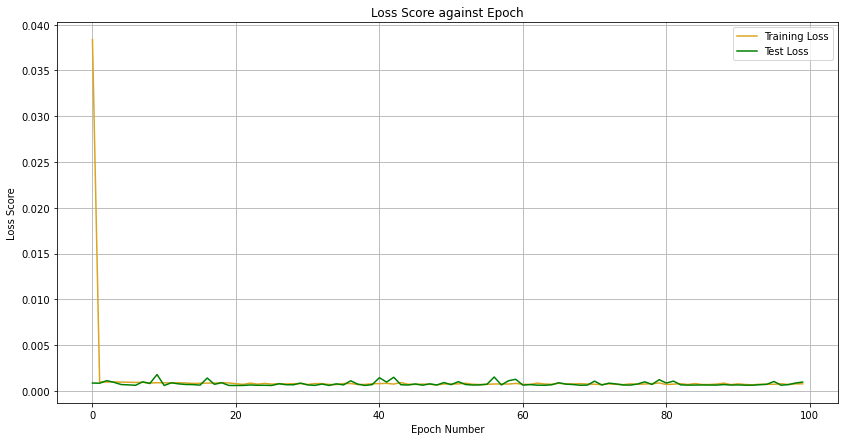

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(b=True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")

ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='green', label='Test Loss')
ax.legend();

### Evaluation

There are a few metrics that can be used to evaluate the performance of a regression model, which include:
* mean squared error (MSE)
* root mean squared error (RMSE)
* mean absolute error (MAE)

We will examine the performance of the model on test set using RMSE.

In [20]:
model.eval()

predictions = []
count = 0

# model predictions
with torch.no_grad():
    for i, (X, y) in enumerate(DataLoader(test_Dataset, 1)):
        count += 1
        output = model(X)
        predictions.append(output.item())
        
# convert list into np array and inverse transform it into proper values before feature scaling
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(1,-1))

# remove beginning 3 rows of data since at least 3 data are needed to make a prediction
df_test = df_test.iloc[3:]
df_test['preds'] = predictions.squeeze()

# compute MSE
rmse_test = mean_squared_error(df_test.preds, df_test.total_power_consumption, squared=False)
print(f"The RMSE for the Testing Dataset is {rmse_test}")

The RMSE for the Testing Dataset is 2573.147833399535


In [21]:
model.eval()

predictions = []
count = 0

# model predictions
with torch.no_grad():
    for i, (X, y) in enumerate(DataLoader(train_Dataset, 1)):
        count += 1
        output = model(X)
        predictions.append(output.item())
        
# convert list into np array and inverse transform it into proper values before feature scaling
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(1,-1))

# remove beginning 3 rows of data since at least 3 data are needed to make a prediction
df_train = df_train.iloc[3:]
df_train['preds'] = predictions.squeeze()

# compute MSE
rmse_train = mean_squared_error(df_train.preds, df_train.total_power_consumption, squared=False)
print(f"The RMSE for the Training Dataset is {rmse_train}")

The RMSE for the Training Dataset is 2302.596699227222


We can also print and visualize predictions made by the model for inspection purpose.

582    44501.045026
583    44516.905298
584    45352.322837
585    44615.944648
586    46295.603017
           ...     
823    55392.942603
824    58452.764463
825    53756.701913
826    53764.998661
827    52541.302186
Name: preds, Length: 246, dtype: float64


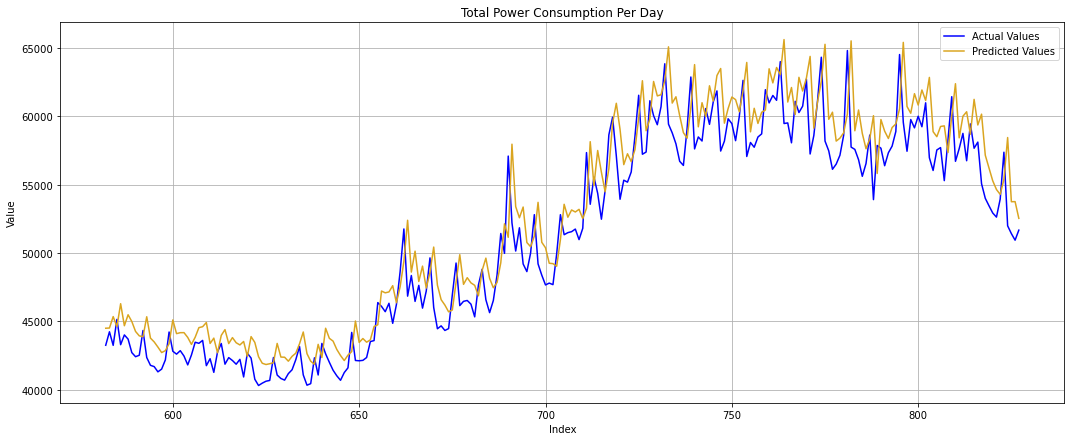

In [22]:
print(df_test['preds'])

# plot time plot for predictions and ground truth 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Total Power Consumption Per Day")
ax.grid(b=True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_test['total_power_consumption'],
    color='blue', label='Actual Values');
ax.plot(
    df_test['preds'],
    color='goldenrod', label='Predicted Values')
ax.legend();